In [78]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import datetime
from torchinfo import summary
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import pdb
#디버깅 하는것도 설명 <<

In [26]:
#hyperparameter & path setting
batch_size=128
lr=1e-2
latent_dim=8
epochs=20

data_path='/data/home/ppleeqq/data/credit/'
model_path='./ae_save_models/'
log_path='./ae_logs/'
Train=True

#랜덤 시드 설정
seed = 40
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 차원축소 & classification
- DNN으로 데이터 classification을 진행해보자
- 그 후에 오토인코더로 차원축소하고 그 데이터로 DNN bification을 진행하며 무슨 차이가 있는지 보자
- credit data는 unsupervised xification dataset이라 train set에 label이 없다!
- 저번엔 따로 불러오기만 하면 됐었는데 원래 train validation test를 나눠주는 경우는 잘 없으니까 이번엔 직접 나눠보자

In [67]:

class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)
        data = df.drop(columns=['ID', 'Class']).values
        labels = df['Class'].values
        
        #pdb.set_trace()
        train_data, val_data, train_labels, val_labels = train_test_split(data,labels, test_size=0.2, stratify=labels,random_state=1)
        val_data, test_data, val_labels, test_labels = train_test_split(val_data ,val_labels, test_size=0.5, stratify=val_labels,random_state=1)
        
        scaler = MinMaxScaler()
        train_data = scaler.fit_transform(train_data)
        val_data = scaler.transform(val_data)
        test_data = scaler.transform(test_data)

    

        self.train_dataset = TensorDataset(torch.FloatTensor(train_data),torch.FloatTensor(train_labels))
        self.val_dataset = TensorDataset(torch.FloatTensor(val_data),torch.FloatTensor(val_labels))
        self.test_dataset = TensorDataset(torch.FloatTensor(test_data),torch.FloatTensor(test_labels))

        # self.train_data = torch.FloatTensor(train_data)
        # self.train_labels = torch.FloatTensor(train_labels)
        # self.val_data = torch.FloatTensor(val_data)
        # self.val_labels = torch.FloatTensor(val_labels)
        # self.test_data = torch.FloatTensor(test_data)
        # self.test_labels = torch.FloatTensor(test_labels)

    def __getitem__(self, index):
        if hasattr(self, 'train_data') and index < len(self.train_data):
            x, y = self.train_data[index], self.train_labels[index]
        elif hasattr(self, 'val_data') and index < len(self.val_data):
            x, y = self.val_data[index], self.val_labels[index]
        elif hasattr(self, 'test_data') and index < len(self.test_data):
            x, y = self.test_data[index], self.test_labels[index]
        else:
            raise IndexError("Index out of range.")
        
        return x, y

    def __len__(self):
        if hasattr(self, 'train_data'):
            return len(self.train_data)
        elif hasattr(self, 'val_data'):
            return len(self.val_data)
        elif hasattr(self, 'test_data'):
            return len(self.test_data)
        else:
            return 0

# 데이터 불러오기 (train 데이터로 설정)
dataset = CustomDataset(data_path+'val.csv')


In [69]:
#몇개씩 나눠졌는지 확인하고
print(f"Training Data Size : {len(dataset.train_dataset)}")
print(f"Validation Data Size : {len(dataset.val_dataset)}")
print(f"Testing Data Size : {len(dataset.test_dataset)}")

Training Data Size : 22769
Validation Data Size : 2846
Testing Data Size : 2847


In [70]:
# #x,y 합쳐주고
# train_dataset = TensorDataset(dataset.train_data, dataset.train_labels)
# val_dataset = TensorDataset(dataset.val_data, dataset.val_labels)
# test_dataset = TensorDataset(dataset.test_data, dataset.test_labels)

#데이터 로더 넣어주고
train_dataloader = DataLoader(dataset.train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(dataset.val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset.test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [71]:
# 인코더 정의
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(30, 15)
        self.l2 = nn.Linear(15, 8)
        self.l3 = nn.Linear(8, 4)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        return x

# 디코더 정의
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(4, 8)
        self.l2 = nn.Linear(8, 15)
        self.l3 = nn.Linear(15, 30)
        self.relu = nn.ReLU()
        self.sigmoid=nn.Sigmoid()

    def forward(self, z):
        z = self.l1(z)
        z = self.relu(z)
        z = self.l2(z)
        z = self.relu(z)
        z = self.l3(z)
        z = self.relu(z)
        z= self.sigmoid(z)
        return z

#맨날 렐루만 하면 재미없으니까 리키렐루를 이용해보자
#보통은 렐루로 해보고 성능이 별로면 이것저것 적용해보는게 좋은 것 같음
# binary 분류라 sigmoid 적용했지만 multi classification인 경우 softmax로 변경하면 됨
class DNN(nn.Module):
    def __init__(self,input_col):
        super(DNN, self).__init__()
        self.l1 = nn.Linear(input_col, 4)
        self.l2 = nn.Linear(4, 1)
        self.leakyrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.l1(x)
        x = self.leakyrelu(x)
        x = self.l2(x)
        x = self.leakyrelu(x)
        x = self.sigmoid(x)
        return x

#오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# 이런 식으로 인코더와 디코더를 따로 정의한다면
# 나중에 인코더의 차원축소만 필요할 때, 굳이 오토인코더를 통째로 돌리지 않고
# 인코더만 불러서 돌릴 수 있다.
# 더 복잡한 모델을 짤 수 있는 것도 덤
# ________________________________________________________

#분류 모델 정의
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.encoder = Encoder()
        self.dnn = DNN(4)

    def forward(self, x):
        encoded = self.encoder(x)
        z = self.dnn(encoded)
        return  z



In [72]:
# 모델이 잘 적합되었는지 확인
model1=Autoencoder()
model1.to(device)
print(device)

cuda


In [73]:
#위처럼 오토인코더 구조를 확인할 경우 무슨 레이어가 있는지는 알지만 순서는 알 수 없음.
#따라서 torchinfo의 summary 모듈을 import하여 확인
summary(model1, (128, 113842,30))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              --                        --
├─Encoder: 1-1                           [128, 113842, 4]          --
│    └─Linear: 2-1                       [128, 113842, 15]         465
│    └─ReLU: 2-2                         [128, 113842, 15]         --
│    └─Linear: 2-3                       [128, 113842, 8]          128
│    └─ReLU: 2-4                         [128, 113842, 8]          --
│    └─Linear: 2-5                       [128, 113842, 4]          36
│    └─ReLU: 2-6                         [128, 113842, 4]          --
├─Decoder: 1-2                           [128, 113842, 30]         --
│    └─Linear: 2-7                       [128, 113842, 8]          40
│    └─ReLU: 2-8                         [128, 113842, 8]          --
│    └─Linear: 2-9                       [128, 113842, 15]         135
│    └─ReLU: 2-10                        [128, 113842, 15]         --
│    └─Linea

In [74]:
# 모델이 잘 적합되었는지 확인
model2=Classifier()
model2.to(device)
summary(Classifier(), (128, 113842,30))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               --                        --
├─Encoder: 1-1                           [128, 113842, 4]          --
│    └─Linear: 2-1                       [128, 113842, 15]         465
│    └─ReLU: 2-2                         [128, 113842, 15]         --
│    └─Linear: 2-3                       [128, 113842, 8]          128
│    └─ReLU: 2-4                         [128, 113842, 8]          --
│    └─Linear: 2-5                       [128, 113842, 4]          36
│    └─ReLU: 2-6                         [128, 113842, 4]          --
├─DNN: 1-2                               [128, 113842, 1]          --
│    └─Linear: 2-7                       [128, 113842, 4]          20
│    └─LeakyReLU: 2-8                    [128, 113842, 4]          --
│    └─Linear: 2-9                       [128, 113842, 1]          5
│    └─LeakyReLU: 2-10                   [128, 113842, 1]          --
│    └─Sigmoid

### 일단 DNN 으로 그냥 분류를 진행해보자

In [75]:
#손실함수, optimizer 정의
# 손실함수 선택할 때, 오토인코더니까 mse loss나 로 정의했지만
# dnn 할 때는 binary classification이니까 binary cross entropy loss로 해보자
model_dnn=DNN(30).to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model_dnn.parameters(), lr=lr)


model_dnn.train()
total_loss = 0.0
total_batches = 0
average_loss=[]

# 학습
if Train : 
    for epoch in range(epochs):
        now1=datetime.datetime.now()
        for x,y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            
            #모델 파라미터의 gradient 초기화
            optimizer.zero_grad()
            
            output = model_dnn(x)
            #loss 계산
            loss = criterion(output, y)
            #loss를 사용해 backpropagation으로 gradient 계산
            loss.backward()
            #계산한 gradient로 모델의 parameter 업데이트
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1

        if epoch==0: 
            now2=datetime.datetime.now()
            print(f"예상완료시각: {now2+(now2-now1)*epochs}")    
        average_loss.append(total_loss / total_batches)
        print(f"Epoch: {epoch}, Average Loss: {total_loss / total_batches:.6f}")

    now=datetime.datetime.now()
    formatted=now.strftime('%m_%d_%H_%M')

    model_name = f'classification_DNN_Fraud_{formatted}.pt'
    torch.save(model_dnn.state_dict(),  model_path + model_name)
    print(f'Model saved at { model_path + model_name}')

else:
    model_name = f'classification_DNN_Fraud_07_06_13_48.pt'
    model_dnn.load_state_dict(torch.load( model_path +  model_name))
    print('model parameter: ',model_dnn.parameters())



/home/ppleeqq/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


예상완료시각: 2023-07-24 11:24:11.745842
Epoch: 0, Average Loss: 0.393765
Epoch: 1, Average Loss: 0.217385
Epoch: 2, Average Loss: 0.149839
Epoch: 3, Average Loss: 0.114914
Epoch: 4, Average Loss: 0.093662
Epoch: 5, Average Loss: 0.079395
Epoch: 6, Average Loss: 0.069162
Epoch: 7, Average Loss: 0.061470
Epoch: 8, Average Loss: 0.055481
Epoch: 9, Average Loss: 0.050686
Epoch: 10, Average Loss: 0.046737
Epoch: 11, Average Loss: 0.043467
Epoch: 12, Average Loss: 0.040699
Epoch: 13, Average Loss: 0.038327
Epoch: 14, Average Loss: 0.036255
Epoch: 15, Average Loss: 0.034458
Epoch: 16, Average Loss: 0.032871
Epoch: 17, Average Loss: 0.031445
Epoch: 18, Average Loss: 0.030168
Epoch: 19, Average Loss: 0.029021
Model saved at ./ae_save_models/classification_DNN_Fraud_07_24_11_24.pt


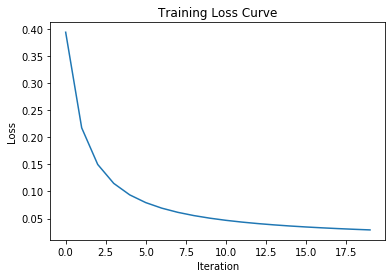

In [76]:
# loss가 잘 줄어드는지 확인
plt.figure()
plt.plot(average_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [94]:
pred=[]
targets=[]


with torch.no_grad():
    # parameter update 하지 말라고 써주는거
    model_dnn.eval()
    for x,y in val_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model_dnn(x)
        pred.extend(output.squeeze().tolist())
        targets.extend(y.tolist())

print(pred)

binary_pred = [1 if i >= 0.0015 else 0 for i in pred]

accuracy = accuracy_score(targets, binary_pred)

print('Accuracy: ',accuracy)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(targets, binary_pred)

# Precision 계산
precision = precision_score(targets, binary_pred)

# Recall 계산
recall = recall_score(targets, binary_pred)

# 결과 출력
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
        

[0.0008926435839384794, 0.0009836190147325397, 0.0009935748530551791, 0.00092420814326033, 0.000936736527364701, 0.0009742113179527223, 0.0009760779794305563, 0.0013302324805408716, 0.000858943909406662, 0.0010905603412538767, 0.0008675191784277558, 0.001092847203835845, 0.0012636736501008272, 0.0012451326474547386, 0.0010516699403524399, 0.000938544690143317, 0.0010898240143433213, 0.000975977978669107, 0.0008834897889755666, 0.0008906750590540469, 0.0011240644380450249, 0.0008197207935154438, 0.000897836172953248, 0.0007858460303395987, 0.0013328874483704567, 0.000858629762660712, 0.0010881428606808186, 0.0009767597075551748, 0.0010513007873669267, 0.0011508535826578736, 0.001108192722313106, 0.0008934008656069636, 0.001011410728096962, 0.0009510171366855502, 0.000986010185442865, 0.000990983215160668, 0.0010199550306424499, 0.0010288459016010165, 0.0010796501301229, 0.0011854598997160792, 0.0010961765656247735, 0.0009203364024870098, 0.000989634427241981, 0.001016399939544499, 0.001

- imbalanced classification이라 DNN 으로 결과가 멸망해버렸네요 ㅎㅎ
- 다음은 차원축소를 진행하고 DNN으로 classification 해보자!

In [61]:
#손실함수, optimizer 정의
# 손실함수 선택할 때, 오토인코더니까 mse loss나 로 정의했지만
# 아래에서 dnn 할 때는 binary classification이니까 binary cross entropy loss로 해보자
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)

model1.train()
total_loss = 0.0
total_batches = 0
average_loss=[]

# 학습
if Train : 
    for epoch in range(epochs):
        now1=datetime.datetime.now()
        for batch in dataloader:
            #모델 파라미터의 gradient 초기화
            optimizer.zero_grad()
            #dataloader에서 한 row씩 가져오기
            inputs = batch.to(device)
            #모델에 넣기
            _ , outputs = model1(inputs)
            #loss 계산
            loss = criterion(outputs, inputs)
            #loss를 사용해 backpropagation으로 gradient 계산
            loss.backward()
            #계산한 gradient로 모델의 parameter 업데이트
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1

        if epoch==0: 
            now2=datetime.datetime.now()
            print(f"예상완료시각: {now2+(now2-now1)*epochs}")    
        average_loss.append(total_loss / total_batches)
        print(f"Epoch: {epoch}, Average Loss: {total_loss / total_batches:.6f}")

    now=datetime.datetime.now()
    formatted=now.strftime('%m_%d_%H_%M')

    model_name = f'anomaly_autoencoder_Fraud_{formatted}.pt'
    torch.save(model1.state_dict(),  model_path + model_name)
    print(f'Model saved at { model_path + model_name}')

else:
    model_name = f'anomaly_autoencoder_Fraud_07_06_13_48.pt'
    model1.load_state_dict(torch.load( model_path +  model_name))
    print('model parameter: ',model1.parameters())



예상완료시각: 2023-07-21 19:37:38.266890
Epoch: 0, Average Loss: 0.025502
Epoch: 1, Average Loss: 0.025337
Epoch: 2, Average Loss: 0.025269
Epoch: 3, Average Loss: 0.025234
Epoch: 4, Average Loss: 0.025213
Epoch: 5, Average Loss: 0.025198
Epoch: 6, Average Loss: 0.025186
Epoch: 7, Average Loss: 0.025177
Epoch: 8, Average Loss: 0.025170
Epoch: 9, Average Loss: 0.025161
Epoch: 10, Average Loss: 0.025140
Epoch: 11, Average Loss: 0.025121
Epoch: 12, Average Loss: 0.025100
Epoch: 13, Average Loss: 0.025081
Epoch: 14, Average Loss: 0.025064
Epoch: 15, Average Loss: 0.025049
Epoch: 16, Average Loss: 0.025035
Epoch: 17, Average Loss: 0.025023
Epoch: 18, Average Loss: 0.025012
Epoch: 19, Average Loss: 0.025002
Model saved at ./ae_save_models/anomaly_autoencoder_Fraud_07_21_19_37.pt


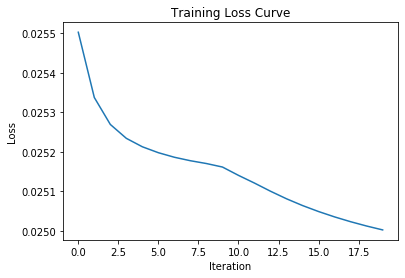

In [62]:
# loss가 잘 줄어드는지 확인
plt.figure()
plt.plot(average_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [ ]:
for epoch in range(epochs):
    now1=datetime.datetime.now()
    for batch in dataloader:
        #모델 파라미터의 gradient 초기화
        optimizer.zero_grad()
        #dataloader에서 한 row씩 가져오기
        inputs = batch.to(device)
        #모델에 넣기
        _ , outputs = model1(inputs)
        #loss 계산
        loss = criterion(outputs, inputs)
        #loss를 사용해 backpropagation으로 gradient 계산
        loss.backward()
        #계산한 gradient로 모델의 parameter 업데이트
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    if epoch==0: 
        now2=datetime.datetime.now()
        print(f"예상완료시각: {now2+(now2-now1)*epochs}")    
    average_loss.append(total_loss / total_batches)
    print(f"Epoch: {epoch}, Average Loss: {total_loss / total_batches:.6f}")

now=datetime.datetime.now()
formatted=now.strftime('%m_%d_%H_%M')

model_name = f'anomaly_autoencoder_Fraud_{formatted}.pt'
torch.save(model1.state_dict(),  model_path + model_name)
print(f'Model saved at { model_path + model_name}')

else:
model_name = f'anomaly_autoencoder_Fraud_07_06_13_48.pt'
model1.load_state_dict(torch.load( model_path +  model_name))
print('model parameter: ',model1.parameters())
